# Setup

In [1]:
# Standard Python libraries
import sys
import random
import string
import os

# Third party libraries
from pylibdmtx.pylibdmtx import encode
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Custom funcs
sys.path.append('../scripts')
from hourglass import *

cuda


# Data Synthesis

In [ ]:
def gen_string():
    '''
    Generates a serial number to encode
    
    Serial numbers are:
    - 11 characters long
    - Index 0, 2, 4, 5, 6, 7, 8, 9, 10 are random digits
    - Index 1 and 3 are uppercase letters
    - Index 11, 12, 13, 14 are an incremental number starting from 0001

    Example serial number: 4 L 4 N 0418028 0001
    '''

    to_encode = ''

    # first 11 indexes
    for j in range(11):
        # 1 and 3 are uppercase
        if j in [1, 3]:
            to_encode += random.choice(string.ascii_uppercase)
        else:
            to_encode += str(random.randrange(0, 10))

    # last 4 indexes
    end = str(random.randrange(1, 99))
    if len(end) == 1:
        end = '0' + end
    elif len(end) == 2:
        end = '00' + end
    else:
        end = '000' + end
    to_encode += end

    return to_encode

def encode_image(to_encode):
    '''Creates a PIL image containing DMC encoding of given string'''

    encoded = encode(to_encode.encode('utf8'))
    img = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels).convert('L')

    # upscale image
    img = img.resize((256, 256), Image.NEAREST)

    return img

def get_corner_coords(img, debug=False):
    '''Returns the coordinates of corners of DMC'''
    padding = 26 # Padding around DMC info zone in pixels (we only want inner modules!)

    raw_coords = [] # Raw pixel coords of dmc corners
    label_info = [] # Line by line label info

    # Get coords of each corner of DMC
    top_left = (padding-1, padding-1)
    top_right = (img.width-padding, padding-1)
    bottom_left = (padding-1, img.height-padding)
    bottom_right = (img.width-padding, img.height-padding)

    # Paint corners red for viz/debug
    if debug:
        img = img.convert('RGB')
        img.putpixel(top_left, (255, 0, 0))
        img.putpixel(top_right, (255, 0, 0))
        img.putpixel(bottom_left, (255, 0, 0))
        img.putpixel(bottom_right, (255, 0, 0))

    # Normalize pixel coords to 0-1
    top_left_norm = [top_left[0] / img.width, top_left[1] / img.height]
    top_right_norm = [top_right[0] / img.width, top_right[1] / img.height]
    bottom_left_norm = [bottom_left[0] / img.width, bottom_left[1] / img.height]
    bottom_right_norm = [bottom_right[0] / img.width, bottom_right[1] / img.height]

    # Add raw coords
    raw_coords.extend([top_left, top_right, bottom_left, bottom_right])

    # Add normalized coords
    label_info.extend([top_left_norm, top_right_norm, bottom_left_norm, bottom_right_norm])

    return raw_coords, label_info, img

def get_heatmaps(img, raw_coords, label_info, heatmap_size, debug=False):
    '''Returns heatmaps for each corner of DMC'''

    # Create empty heatmaps
    heatmaps = np.zeros((4, heatmap_size, heatmap_size))

    # Create gaussian heatmaps for each corner
    for i in range(4):
        # Create gaussian heatmap
        heatmap = np.zeros((img.height, img.width))
        for y in range(img.height):
            for x in range(img.width):
                heatmap[y, x] = np.exp(-((x - raw_coords[i][0])**2 + (y - raw_coords[i][1])**2) / (2 * 2**2))

        # Scale down to 64x64
        heatmap = cv2.resize(heatmap, (heatmap_size, heatmap_size))

        # Add heatmap to heatmaps
        heatmaps[i] = heatmap

    # Paint heatmaps on image for viz/debug
    if debug:
        # Scale up heatmaps to image size
        debug_heatmaps = []
        for i in range(4):
            debug_heatmaps.append(cv2.resize(heatmaps[i], (img.width, img.height)))
        for i in range(4):
            for y in range(img.height):
                for x in range(img.width):
                    if debug_heatmaps[i][y, x] > 0:
                        img.putpixel((x, y), (int(debug_heatmaps[i][y, x] * 255), 0, 0))

    return heatmaps, img

[(25, 25), (230, 25), (25, 230), (230, 230)]
[[0.09765625, 0.09765625], [0.8984375, 0.09765625], [0.09765625, 0.8984375], [0.8984375, 0.8984375]]
(4, 64, 64)
(64, 64)
[[9.22424957e-59 1.22236334e-49 2.99105540e-42 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.22236334e-49 1.61983055e-40 3.96363567e-33 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.99105540e-42 3.96363567e-33 9.69879701e-26 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


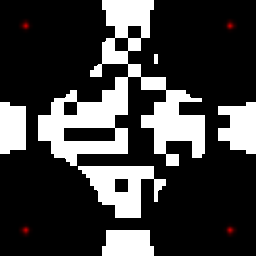

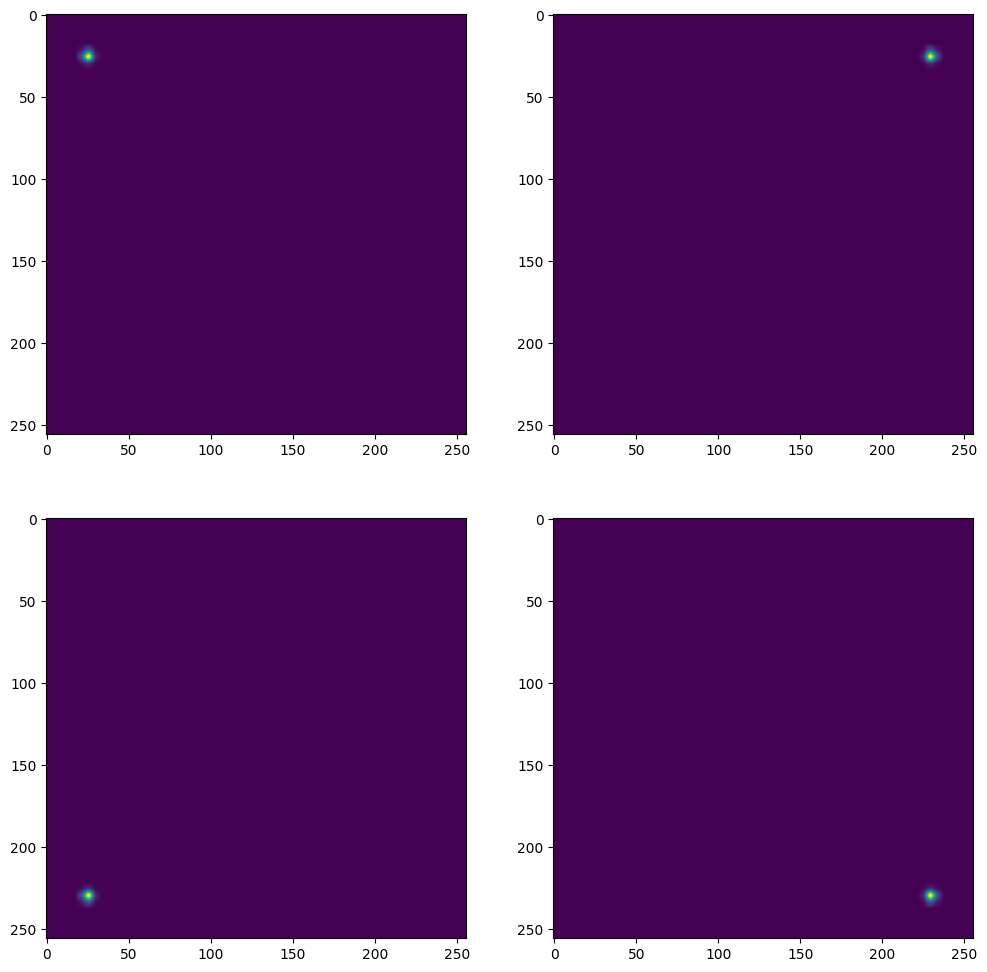

In [3]:
# testing functions
test = gen_string()
img = encode_image(test)
raw_coords, label_info, img = get_corner_coords(img, debug=True)
print(raw_coords)
print(label_info)
heatmaps, img = get_heatmaps(img, raw_coords, label_info, heatmap_size=64, debug=True)
print(heatmaps.shape)
print(heatmaps[0].shape)
print(heatmaps[0])

# Display image
display(img)

# Display heatmaps
plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    heatmap = heatmaps[i]
    # scale up to 256x256
    heatmap = cv2.resize(heatmap, (256, 256))
    plt.imshow(heatmap)
plt.show()

In [ ]:
def gen_save(type):
    '''Generates a random serial number, encodes it into a DMC image, and saves it to train/val/test folders'''

    to_encode = gen_string()
    img = encode_image(to_encode)

    # Get corner values
    raw_coords, label_info, img = get_corner_coords(img)

    # Get heatmaps
    heatmaps, img = get_heatmaps(img, raw_coords, label_info, heatmap_size=64, debug=False)

    # Convert heatmaps to tensor
    heatmaps = torch.tensor(heatmaps).float()

    # Save label
    torch.save(heatmaps, f'../data/hourglass_localization_rectification/simple_synth/labels/{type}/{to_encode}.pt')

    # Convert images to RGB
    img = img.convert('RGB')

    # Normalize image
    img = np.array(img)
    img = img / 255
    img = torch.tensor(img).float()
    img = img.permute(2, 0, 1)

    # Save image
    torch.save(img, f'../data/hourglass_localization_rectification/simple_synth/images/{type}/{to_encode}.pt')

    return

def delete_old():
    '''Deletes all images and labels in train/val/test folders'''

    for folder in ['train', 'val', 'test']:
        for file in os.listdir(f'../data/hourglass_localization_rectification/simple_synth/images/{folder}'):
            os.remove(f'../data/hourglass_localization_rectification/simple_synth/images/{folder}/{file}')

        for file in os.listdir(f'../data/hourglass_localization_rectification/simple_synth/labels/{folder}'):
            os.remove(f'../data/hourglass_localization_rectification/simple_synth/labels/{folder}/{file}')

    return

In [5]:
# delete old images and labels
delete_old()

In [6]:
# generating train/val/test datasets
n_train = 800
n_val = 100
n_test = 100

print('Generating train images...')
for i in range(n_train - len(os.listdir('../data/hourglass_localization_rectification/simple_synth/images/train'))):
    gen_save('train')

print('Generating val images...')
for i in range(n_val - len(os.listdir('../data/hourglass_localization_rectification/simple_synth/images/val'))):
    gen_save('val')

print('Generating test images...')
for i in range(n_test - len(os.listdir('../data/hourglass_localization_rectification/simple_synth/images/test'))):
    gen_save('test')

Generating train images...
Generating val images...
Generating test images...


In [7]:
# Dataloader
class DMC_Dataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = os.listdir(image_dir)
        self.label_files = os.listdir(label_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = torch.load(f'{self.image_dir}/{self.image_files[idx]}')
        label = torch.load(f'{self.label_dir}/{self.label_files[idx]}')

        return image, label

train_dataset = DMC_Dataset(
    image_dir='../data/hourglass_localization_rectification/simple_synth/images/train',
    label_dir='../data/hourglass_localization_rectification/simple_synth/labels/train',
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
)

# Stacked Hourglass Setup

In [8]:
# Example usage with dataloader
model = StackedHourglassNetwork(
    num_stacks=3,
    num_features=256,
    num_output_points=4,
)

for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    output = model(images)
    print(output.shape) # Expected: (8, 4, H, W) representing 4 heatmaps per image
    break
print(output)

torch.Size([8, 3, 256, 256])
torch.Size([8, 4, 64, 64])
torch.Size([8, 4, 64, 64])
tensor([[[[ 8.4625e+01,  8.6948e+01,  8.2596e+01,  ...,  8.4755e+01,
            9.2639e+01,  8.9546e+01],
          [ 8.5055e+01,  8.8607e+01,  8.4004e+01,  ...,  8.8029e+01,
            9.6204e+01,  9.0412e+01],
          [ 8.1139e+01,  8.3359e+01,  8.1415e+01,  ...,  8.4184e+01,
            9.2052e+01,  8.7468e+01],
          ...,
          [ 7.5242e+01,  7.8016e+01,  7.3822e+01,  ...,  8.9347e+01,
            9.6602e+01,  9.2758e+01],
          [ 7.6461e+01,  7.8364e+01,  7.7868e+01,  ...,  9.5272e+01,
            9.7068e+01,  9.2314e+01],
          [ 7.6562e+01,  7.7331e+01,  7.7258e+01,  ...,  9.5457e+01,
            9.6561e+01,  9.3751e+01]],

         [[-4.8001e+01, -5.0290e+01, -4.8683e+01,  ..., -6.5919e+01,
           -6.2101e+01, -6.1995e+01],
          [-4.8326e+01, -4.8648e+01, -4.6808e+01,  ..., -6.3877e+01,
           -5.9377e+01, -5.9726e+01],
          [-4.5482e+01, -4.7068e+01, -4.3888

(4, 64, 64)


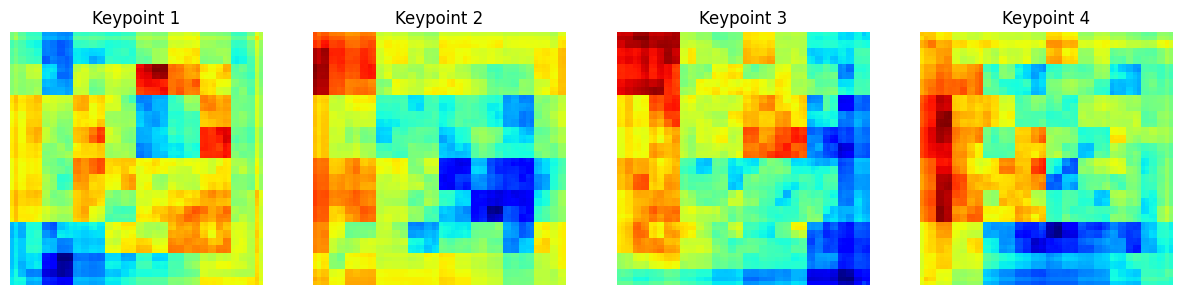

In [9]:
# Convert tensor to numpy for visualization
heatmaps = output[0].detach().cpu().numpy()  # Shape: (4, H, W)
print(heatmaps.shape)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(heatmaps[i], cmap='jet')
    axes[i].set_title(f'Keypoint {i+1}')
    axes[i].axis('off')

plt.show()

In [10]:
def extract_keypoints(heatmaps, input_size=256, output_size=64):
    scale = input_size / output_size  # Scale factor to match original resolution
    keypoints = []
    for i in range(heatmaps.shape[0]):  # Iterate over keypoint heatmaps
        hmap = heatmaps[i]
        y, x = np.unravel_index(np.argmax(hmap), hmap.shape)  # Get max index
        keypoints.append((int(x * scale), int(y * scale)))  # Scale keypoints
    return keypoints

def heatmap_viz(image, keypoints, heatmaps, alpha=0.5):
    # Combined figure
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    # Original image with keypoints
    image_kp = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert for OpenCV
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)] # Colors are blue, green, red, yellow (BGR)
    for i, (x, y) in enumerate(keypoints):
        cv2.circle(image_kp, (x, y), 5, colors[i], -1)  # Draw colored circle
    axes[0].imshow(cv2.cvtColor(image_kp, cv2.COLOR_BGR2RGB))
    axes[0].axis("off")
    axes[0].set_title("Image")

    # Heatmaps
    for i, heatmap in enumerate(heatmaps):
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize to input image size
        heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min())  # Normalize
        heatmap_colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Apply color map
        overlay = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)  # Blend images
        axes[i+1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axes[i+1].axis("off")

        if i == 0:
            axes[i+1].set_title("Heatmap (blue)")
        elif i == 1:
            axes[i+1].set_title("Heatmap (green)")
        elif i == 2:
            axes[i+1].set_title("Heatmap (red)")
        elif i == 3:
            axes[i+1].set_title("Heatmap (yellow)")
    
    plt.show()

(4, 64, 64)
Predicted keypoints: [(220, 108), (124, 60), (200, 144), (36, 112)]


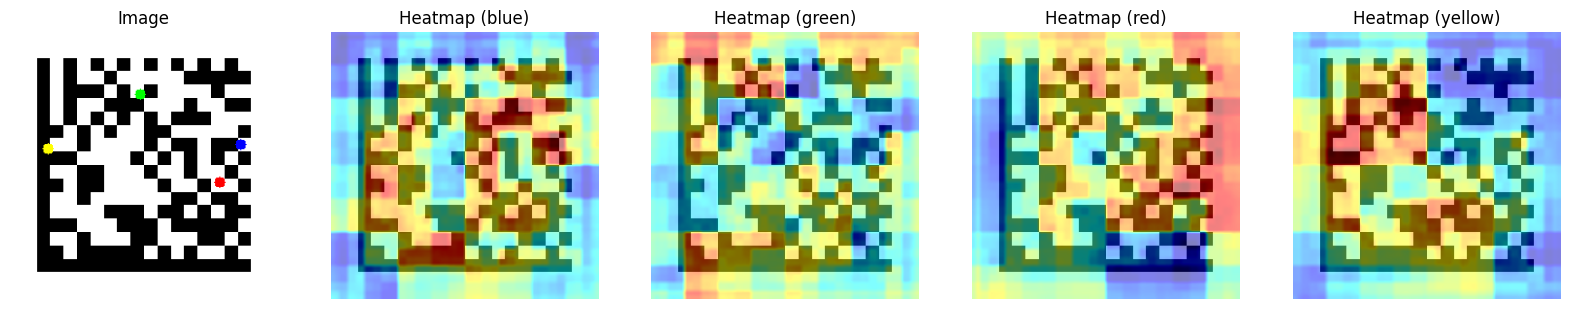

In [11]:
# Example vizualization usage with dataloader
model = StackedHourglassNetwork(
    num_stacks=3,
    num_features=256,
    num_output_points=4,
)

for images, labels in train_loader:
    output = model(images)
    break

heatmaps = output[0].detach().cpu().numpy()  # Convert tensor to numpy
print(heatmaps.shape)
keypoints = extract_keypoints(heatmaps, input_size=256, output_size=64)
print("Predicted keypoints:", keypoints)

img = images[0].permute(1, 2, 0).numpy() * 255
img = img.astype(np.uint8) # Convert to ints only
heatmap_viz(img, keypoints, heatmaps)

(4, 64, 64)
True keypoints: [(24, 24), (228, 24), (24, 228), (228, 228)]


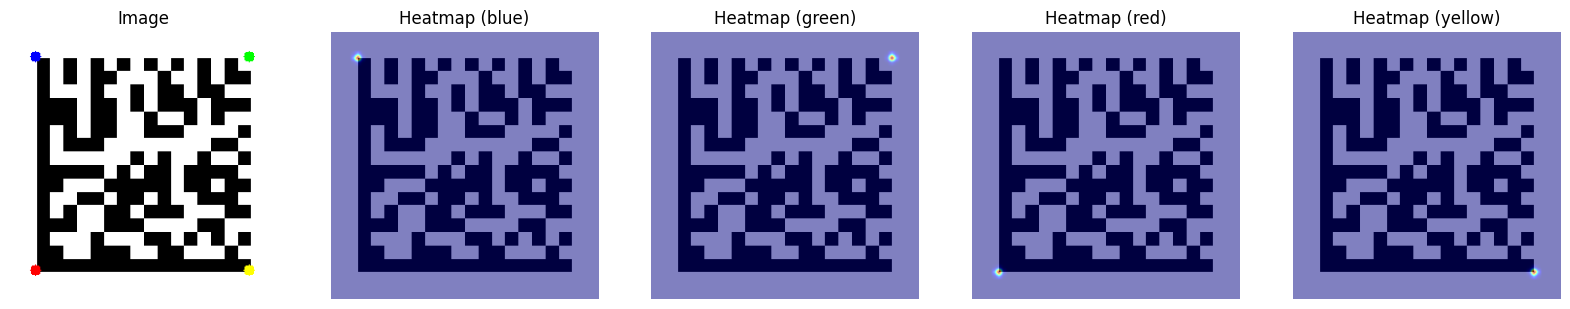

In [12]:
# Example vizualization of true keypoints and heatmaps
for images, labels in train_loader:
    image = images[0].permute(1, 2, 0).numpy() * 255
    image = image.astype(np.uint8) # Convert to ints only

    heatmaps = labels[0].detach().cpu().numpy()  # Convert tensor to numpy
    print(heatmaps.shape)
    keypoints = extract_keypoints(heatmaps, input_size=256, output_size=64)
    print("True keypoints:", keypoints)
    break

heatmap_viz(image, keypoints, heatmaps)

# Model Training

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
# Training function
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = {'train': [], 'val': []} # Store losses
    
    for epoch in range(epochs):
        model.train()

        train_loss = 0
        for images, heatmaps in train_loader:
            images, heatmaps = images.to(device), heatmaps.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        losses['train'].append(train_loss/len(train_loader))

        # validation loop
        model.eval()
        val_loss = 0.0
        count = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, masks)

                val_loss += loss.item()

        losses['val'].append(val_loss/len(val_loader))

        # early stopping if validation loss increases
        if early_stopper.early_stop(val_loss):
            print(f'Early stopping at epoch {epoch}')
            break

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.5f}, Val Loss: {val_loss/len(val_loader):.5f}')

    return model, losses

In [15]:
val_dataset = DMC_Dataset(
    image_dir='../data/hourglass_localization_rectification/simple_synth/images/val',
    label_dir='../data/hourglass_localization_rectification/simple_synth/labels/val',
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=True,
)

In [16]:
model = StackedHourglassNetwork(
    num_stacks=3,
    num_features=256,
    num_output_points=4,
)

print('Initial training...')
early_stopper = EarlyStopper(patience=3, min_delta=0.001)
initial_trained_model, trained_losses_tmp = train_model(model,
                                            train_loader,
                                            val_loader,
                                            epochs=10,
                                            lr=0.001
                                            )
trained_losses = trained_losses_tmp

print('Quick training...')
early_stopper = EarlyStopper(patience=5, min_delta=0.0001)
quick_trained_model, trained_losses_tmp = train_model(initial_trained_model,
                                            train_loader,
                                            val_loader,
                                            epochs=100,
                                            lr=0.0001
                                            )
trained_losses = {key: trained_losses[key] + trained_losses_tmp[key] for key in trained_losses.keys()}

print('Touch up training...')
early_stopper = EarlyStopper(patience=10, min_delta=0.0001)
touchup_trained_model, trained_losses_tmp = train_model(quick_trained_model,
                                            train_loader,
                                            val_loader,
                                            epochs=100,
                                            lr=0.00001
                                            )
trained_losses = {key: trained_losses[key] + trained_losses_tmp[key] for key in trained_losses.keys()}

print('Final training...')
early_stopper = EarlyStopper(patience=10, min_delta=0.00001)
final_trained_model, trained_losses_tmp = train_model(touchup_trained_model,
                                            train_loader,
                                            val_loader,
                                            epochs=100,
                                            lr=0.000001
                                            )
trained_losses = {key: trained_losses[key] + trained_losses_tmp[key] for key in trained_losses.keys()}

print('Training complete!')

Initial training...
Epoch 1/10, Train Loss: 350.23143, Val Loss: 0.67604
Epoch 2/10, Train Loss: 0.43391, Val Loss: 0.30440
Epoch 3/10, Train Loss: 0.29458, Val Loss: 0.21513
Epoch 4/10, Train Loss: 0.21290, Val Loss: 0.19236
Epoch 5/10, Train Loss: 0.18990, Val Loss: 0.15349
Epoch 6/10, Train Loss: 0.18725, Val Loss: 0.14302
Epoch 7/10, Train Loss: 0.14644, Val Loss: 0.11381
Epoch 8/10, Train Loss: 0.16391, Val Loss: 0.08865
Epoch 9/10, Train Loss: 0.15091, Val Loss: 0.07759
Epoch 10/10, Train Loss: 0.12837, Val Loss: 0.06617
Bulk training...
Epoch 1/100, Train Loss: 3.04718, Val Loss: 0.05493
Epoch 2/100, Train Loss: 0.04914, Val Loss: 0.03154
Epoch 3/100, Train Loss: 0.04906, Val Loss: 0.02934
Epoch 4/100, Train Loss: 0.04011, Val Loss: 0.02258
Epoch 5/100, Train Loss: 0.04105, Val Loss: 0.02351
Epoch 6/100, Train Loss: 0.03857, Val Loss: 0.01741
Epoch 7/100, Train Loss: 0.03016, Val Loss: 0.01894
Epoch 8/100, Train Loss: 0.03447, Val Loss: 0.02137
Epoch 9/100, Train Loss: 0.03554, 

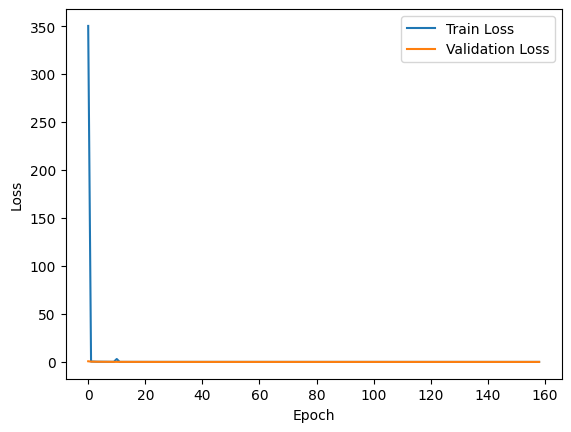

In [17]:
# Show training and validation losses
plt.plot(trained_losses['train'], label='Train Loss')
plt.plot(trained_losses['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Evaluation

In [18]:
test_dataset = DMC_Dataset(
    image_dir='../data/hourglass_localization_rectification/simple_synth/images/test',
    label_dir='../data/hourglass_localization_rectification/simple_synth/labels/test',
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
)

In [19]:
def evaluate_model(model, loader):
    model.eval()

    criterion = nn.MSELoss()

    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            count += 1
        
    print(f'Average loss: {total_loss/count:.4f}')

    return total_loss

In [20]:
# Train loss
evaluate_model(final_trained_model, train_loader)

Average loss: 0.0007


0.06607191712828353

In [21]:
# Val loss
evaluate_model(final_trained_model, val_loader)

Average loss: 0.0007


0.009011514019221067

In [22]:
# Test loss
evaluate_model(final_trained_model, test_loader)

Average loss: 0.0007


0.009054699097760022

## Train Print

0.0006352928467094898
(8, 4, 64, 64)


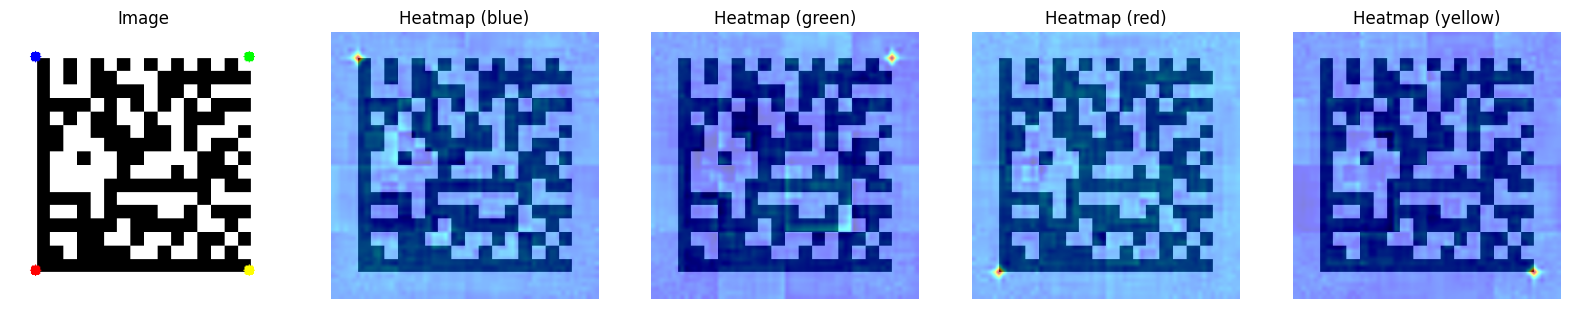

In [23]:
for images, heatmaps in train_loader:
    images, heatmaps = images.to(device), heatmaps.to(device)
    outputs = final_trained_model(images)
    break

# Loss for single image
criterion = nn.MSELoss()
loss = criterion(outputs, heatmaps)
print(loss.item())

outputs = outputs.detach().cpu().numpy()
print(outputs.shape)

for i in range(8):
    image = images[i].permute(1, 2, 0).cpu().numpy() * 255
    image = image.astype(np.uint8) # Convert to ints only
    heatmaps = outputs[i]
    keypoints = extract_keypoints(heatmaps, input_size=256, output_size=64)
    heatmap_viz(image, keypoints, heatmaps)
    break

## Validation Print

(8, 4, 64, 64)


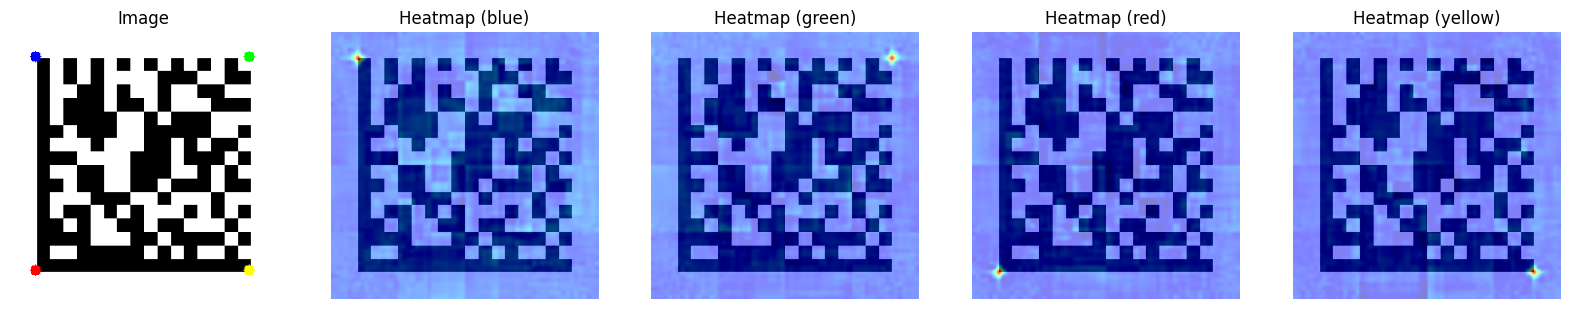

In [25]:
for images, heatmaps in val_loader:
    images, heatmaps = images.to(device), heatmaps.to(device)
    outputs = final_trained_model(images)
    break
outputs = outputs.detach().cpu().numpy()
print(outputs.shape)

for i in range(8):
    image = images[i].permute(1, 2, 0).cpu().numpy() * 255
    image = image.astype(np.uint8) # Convert to ints only
    heatmaps = outputs[i]
    keypoints = extract_keypoints(heatmaps, input_size=256, output_size=64)
    heatmap_viz(image, keypoints, heatmaps)
    break

## Test Print

(8, 4, 64, 64)


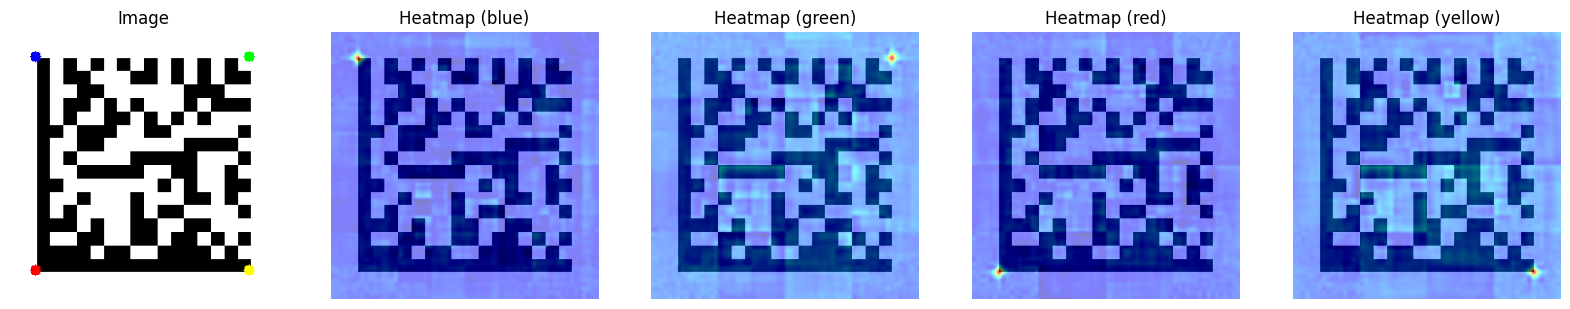

In [26]:
for images, heatmaps in test_loader:
    images, heatmaps = images.to(device), heatmaps.to(device)
    outputs = final_trained_model(images)
    break
outputs = outputs.detach().cpu().numpy()
print(outputs.shape)

for i in range(8):
    image = images[i].permute(1, 2, 0).cpu().numpy() * 255
    image = image.astype(np.uint8) # Convert to ints only
    heatmaps = outputs[i]
    keypoints = extract_keypoints(heatmaps, input_size=256, output_size=64)
    heatmap_viz(image, keypoints, heatmaps)
    break

# Saving Model(s)

In [ ]:
# Save all models
torch.save(initial_trained_model.state_dict(), '../models/hourglass_localization_rectification/initial_trained_model.pth')
torch.save(quick_trained_model.state_dict(), '../models/hourglass_localization_rectification/quick_trained_model.pth')
torch.save(touchup_trained_model.state_dict(), '../models/hourglass_localization_rectification/touchup_trained_model.pth')
torch.save(final_trained_model.state_dict(), '../models/hourglass_localization_rectification/final_trained_model.pth')